# **Mining for Insights** - DSCI 100 Final Project
Anders Lee | Section 003 

<center><img src="minecraft_cover.jpg" width = "800"/><center>



# 1. Introduction

### Context 

Want to slay end-of-the-world dragons or explore the depths of a magical cavern? Look no further than Minecraft: a sandbox video game. Its expansive world-generation creates a unique experience for each player—which is exactly why the Pacific Lab for Artificial Intelligence (PLAI), a research team at UBC, is trying to understand how people play video games.

The research team’s goal is to build an embodied AI, an in-game artificial intelligence that can act, talk, and play just like humans [(PLAI, 2024)](https://blog.plaicraft.ai/2024/10/25/plaicraft-faq/). Since April 2024, PLAI has hosted a server in order to gather player data for their embodied AI model.

While this project is not focused on AI, lots of supplemental data has been collected—some of which details each player’s session time. We can use this data to optimize how the server is managed and maintained in the future. 

### Question

*Can we predict the number of active players on the PLAICraft server at a given hour? Moreover, are there any trends with playtime that we can conclude?* 

### Data Description

Because our question is focused on the peak capacity times of the server, and not the demographics of the player, we’ll use the “sessions.csv” dataset. This player data was captured from April 6, 2024 to September 26, 2024. It contains 1535 observations and 5 variables. These variables consist of: 

* `hashedEmail` which contains an encrypted email (*which can be joined with “players.csv”*)
* `start_time` which documents the date and time which the player logged in to the server
* `end_time` which documents the date and time which the player logged off the server
* `original_start_time` measures the player’s login time since January 1, 1970
* `original_end_time` measures the player’s logoff time since January 1, 1970

# 2. Methodology

### Loading the data

In [35]:
### PLEASE RUN THESE LIBRARIES TO ENSURE THE CODE WORKS!

library(tidyverse)
library(tidymodels)

In [136]:
### this shows a preview of what the sessions.csv looks like!

sessions <- read_csv("data/sessions.csv") 
head(sessions)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail                                                     
1 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3 f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
4 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
5 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
6 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
  start_time       end_time         original_start_time original_end_time
1 30/06/2024 18:12 30/06/2024 18:24 1.71977e+12         1.71977e+12      
2 17/06/2024 23:33 17/06/2024 23:46 1.71867e+12         1.71867e+12      
3 25/07/2024 17:34 25/07/2024 17:57 1.72193e+12         1.72193e+12      
4 25/07/2024 03:22 25/07/2024 03:58 1.72188e+12         1.72188e+12      
5 25/05/2024 16:01 25/05/2024 16:12 1.71665e+12         1.71665e+12      
6 23/06/2024 15:08 23/06/2024 17:10 1.71916e+12         1.71916e+12

### Wrangling the data

This current dataframe is *not tidy*. Notably, the `start_time` and `end_time` have multiple values in a single cell; they contain both a date and a time. However, in R, there is conveniently a data type called `<date-time>`, which consists of a single value. Let's start by making the dates (start and end) a separate column.

In [148]:
sessions_tidy <- sessions |>
    mutate(start_date = substr(start_time, 1, 10)) |>   # the substr function takes part of a string 
                                                        # (the first 10 characters, in this instance)
    mutate(end_date = substr(end_time, 1, 10)) |>
    select(-original_start_time, -original_end_time)    # only selecting the columns we need
head(sessions_tidy)

hashedEmail                                                     
1 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3 f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
4 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
5 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
6 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
  start_time       end_time         start_date end_date  
1 30/06/2024 18:12 30/06/2024 18:24 30/06/2024 30/06/2024
2 17/06/2024 23:33 17/06/2024 23:46 17/06/2024 17/06/2024
3 25/07/2024 17:34 25/07/2024 17:57 25/07/2024 25/07/2024
4 25/07/2024 03:22 25/07/2024 03:58 25/07/2024 25/07/2024
5 25/05/2024 16:01 25/05/2024 16:12 25/05/2024 25/05/2024
6 23/06/2024 15:08 23/06/2024 17:10 23/06/2024 23/06/2024

Now, let's convert the `start_time` and `end_time` from a `<character>` to be a `<dttm>` datatype and the `start_date` to a `<date>` datatype. Once those conversions are made, we can calculate how long each player's session was in minutes.

In [149]:
sessions_proper_time <- sessions_tidy |>
    mutate(start_date =
           as.POSIXct(start_time, format = "%d/%m/%Y %H:%M") # converting from a character datatype to a date & time datatype
        ) |>
    mutate(end_date =
           as.POSIXct(end_time, format = "%d/%m/%Y %H:%M") # converting from a character datatype to a date & time datatype
        ) |>
    mutate(day =
           as.Date(start_time, format = "%d/%m/%Y")
        ) |>
    mutate(session_length = end_date - start_date) |> # this creates a column which details how long each player's session was
    select(-start_time, -end_time)
head(sessions_proper_time)

hashedEmail                                                     
1 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3 f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
4 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
5 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
6 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
  start_date          end_date            day        session_length
1 2024-06-30 18:12:00 2024-06-30 18:24:00 2024-06-30  12 mins      
2 2024-06-17 23:33:00 2024-06-17 23:46:00 2024-06-17  13 mins      
3 2024-07-25 17:34:00 2024-07-25 17:57:00 2024-07-25  23 mins      
4 2024-07-25 03:22:00 2024-07-25 03:58:00 2024-07-25  36 mins      
5 2024-05-25 16:01:00 2024-05-25 16:12:00 2024-05-25  11 mins      
6 2024-06-23 15:08:00 2024-06-23 17:10:00 2024-06-23 122 mins

### Visualizing & exploring the data

With the session length calculated, we can sum this value per day to visualize when **the server, in general, has peaks in player usage**. This helps us understand broader trends on server capacity—on the time frame of days, rather than hours.

day        hours   
1 2024-04-06 182 mins
2 2024-04-07 191 mins
3 2024-04-08 144 mins
4 2024-04-09  56 mins
5 2024-04-14   8 mins
6 2024-04-15  71 mins

Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


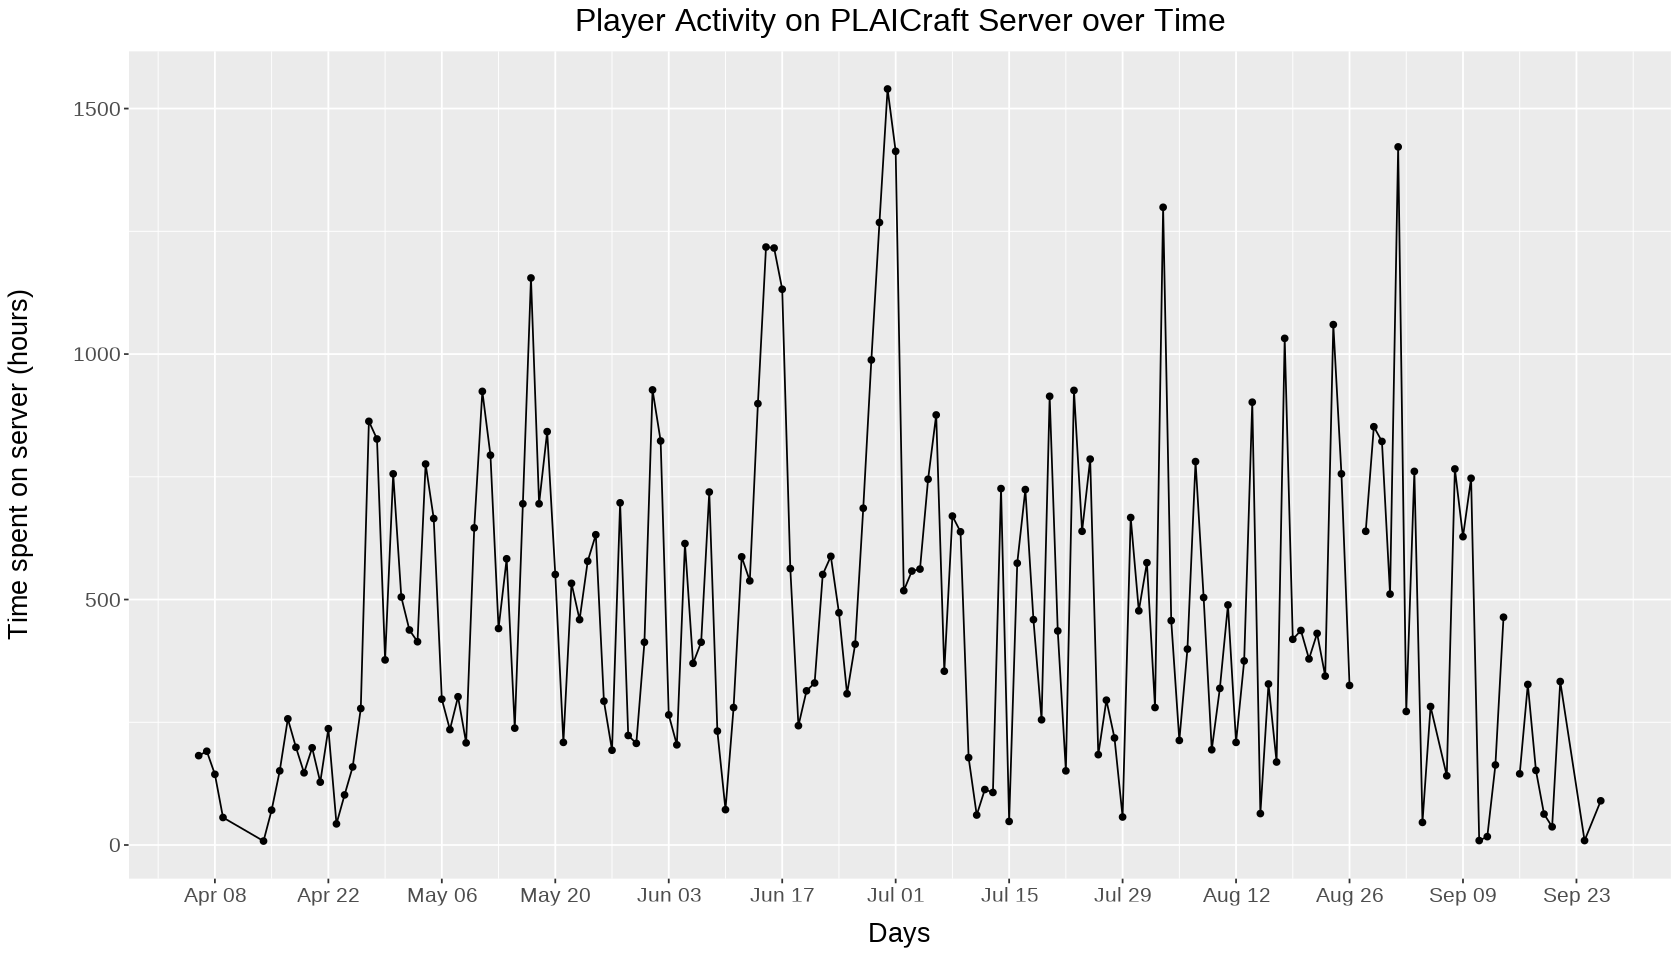

In [153]:
day_analytics <- sessions_proper_time |>
    group_by(day) |>
    summarize(hours = sum(session_length))
head(day_analytics)

options(repr.plot.height = 8, repr.plot.width = 14)
server_capacity <- day_analytics |>
    ggplot(aes(x = day, y = hours)) + 
        geom_point() +
        geom_line() +
        labs(x = "Days", y = "Time spent on server (hours)") +
        scale_x_date(date_labels = "%b %d", date_breaks = "2 weeks") +
        ggtitle("Player Activity on PLAICraft Server over Time") +
        theme(plot.title = element_text(hjust = 0.5)) +
        theme(text = element_text(size = 20))
server_capacity

*<center>Figure 1: This line chart depicts how many hours are spent on the server per day. Each dot represents a single day, and the time interval goes from April 6, 2024 to September 26, 2024. Every date that is labelled is a Monday.<center>*

From this line graph, we can observe that the server is most in demand **during the summer**, especially during July. However, there's also a weekly pattern. Playtime spikes during Fridays, Saturdays, and Sundays, and calms down on Mondays. We can suggest that PLAICraft moderators acquire more licenses during the summer to accomodate more players.

Another interesting question, though slightly tangential to our analysis, might be *what type of players are active and contribute more time to the server*. In order to do this, we'll have to join the `sessions.csv` and the `players.csv` through a common variable from both dataframes—the hashed email. 

In [158]:
players <- read_csv("data/players.csv") # first we have to load and clean the players.csv data
players_tidy <- players |>
    mutate(gender = as.factor(gender)) |>
    mutate(experience = as.factor(experience))

server_data <- players_tidy |>
    inner_join(sessions_proper_time) # the inner join ensures that all columns are retained
head(server_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(hashedEmail)`


experience subscribe
1 Pro        TRUE     
2 Pro        TRUE     
3 Pro        TRUE     
4 Pro        TRUE     
5 Pro        TRUE     
6 Pro        TRUE     
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
3 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
4 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
5 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
6 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
  name   gender Age start_date          end_date            day       
1 Morgan Male   9   2024-08-08 00:21:00 2024-08-08 01:35:00 2024-08-08
2 Morgan Male   9   2024-09-09 22:30:00 2024-09-09 22:37:00 2024-09-09
3 Morgan Male   9   2024-08-08 02:41:00 2024-08-08 03:25:00 2024-08-08
4 Morgan Male   9   2024-09-10 15:07:00 2024-09-10 15:29:00 2024-09-10
5 Morgan Male   9   2024-05-05 22:21:00 2024-05-05 23:17:00 2024-05-05
6 Morgan Male   9   2024-04-06 22:24:00 2024-04-06 23:33:00 2024-04-06
  session_length
1 74 mins       
2  7 mins       
3 44 mins       
4 22 mins       
5 56 mins       
6 69 mins

Of particular note is the `experience` column—one might hypothesize that players with *greater self-described experience would have more and longer sessions on the server*. We can visualize this through a scatter plot, and use `facet_grid` to create a matrix of charts based on `experience`.

Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


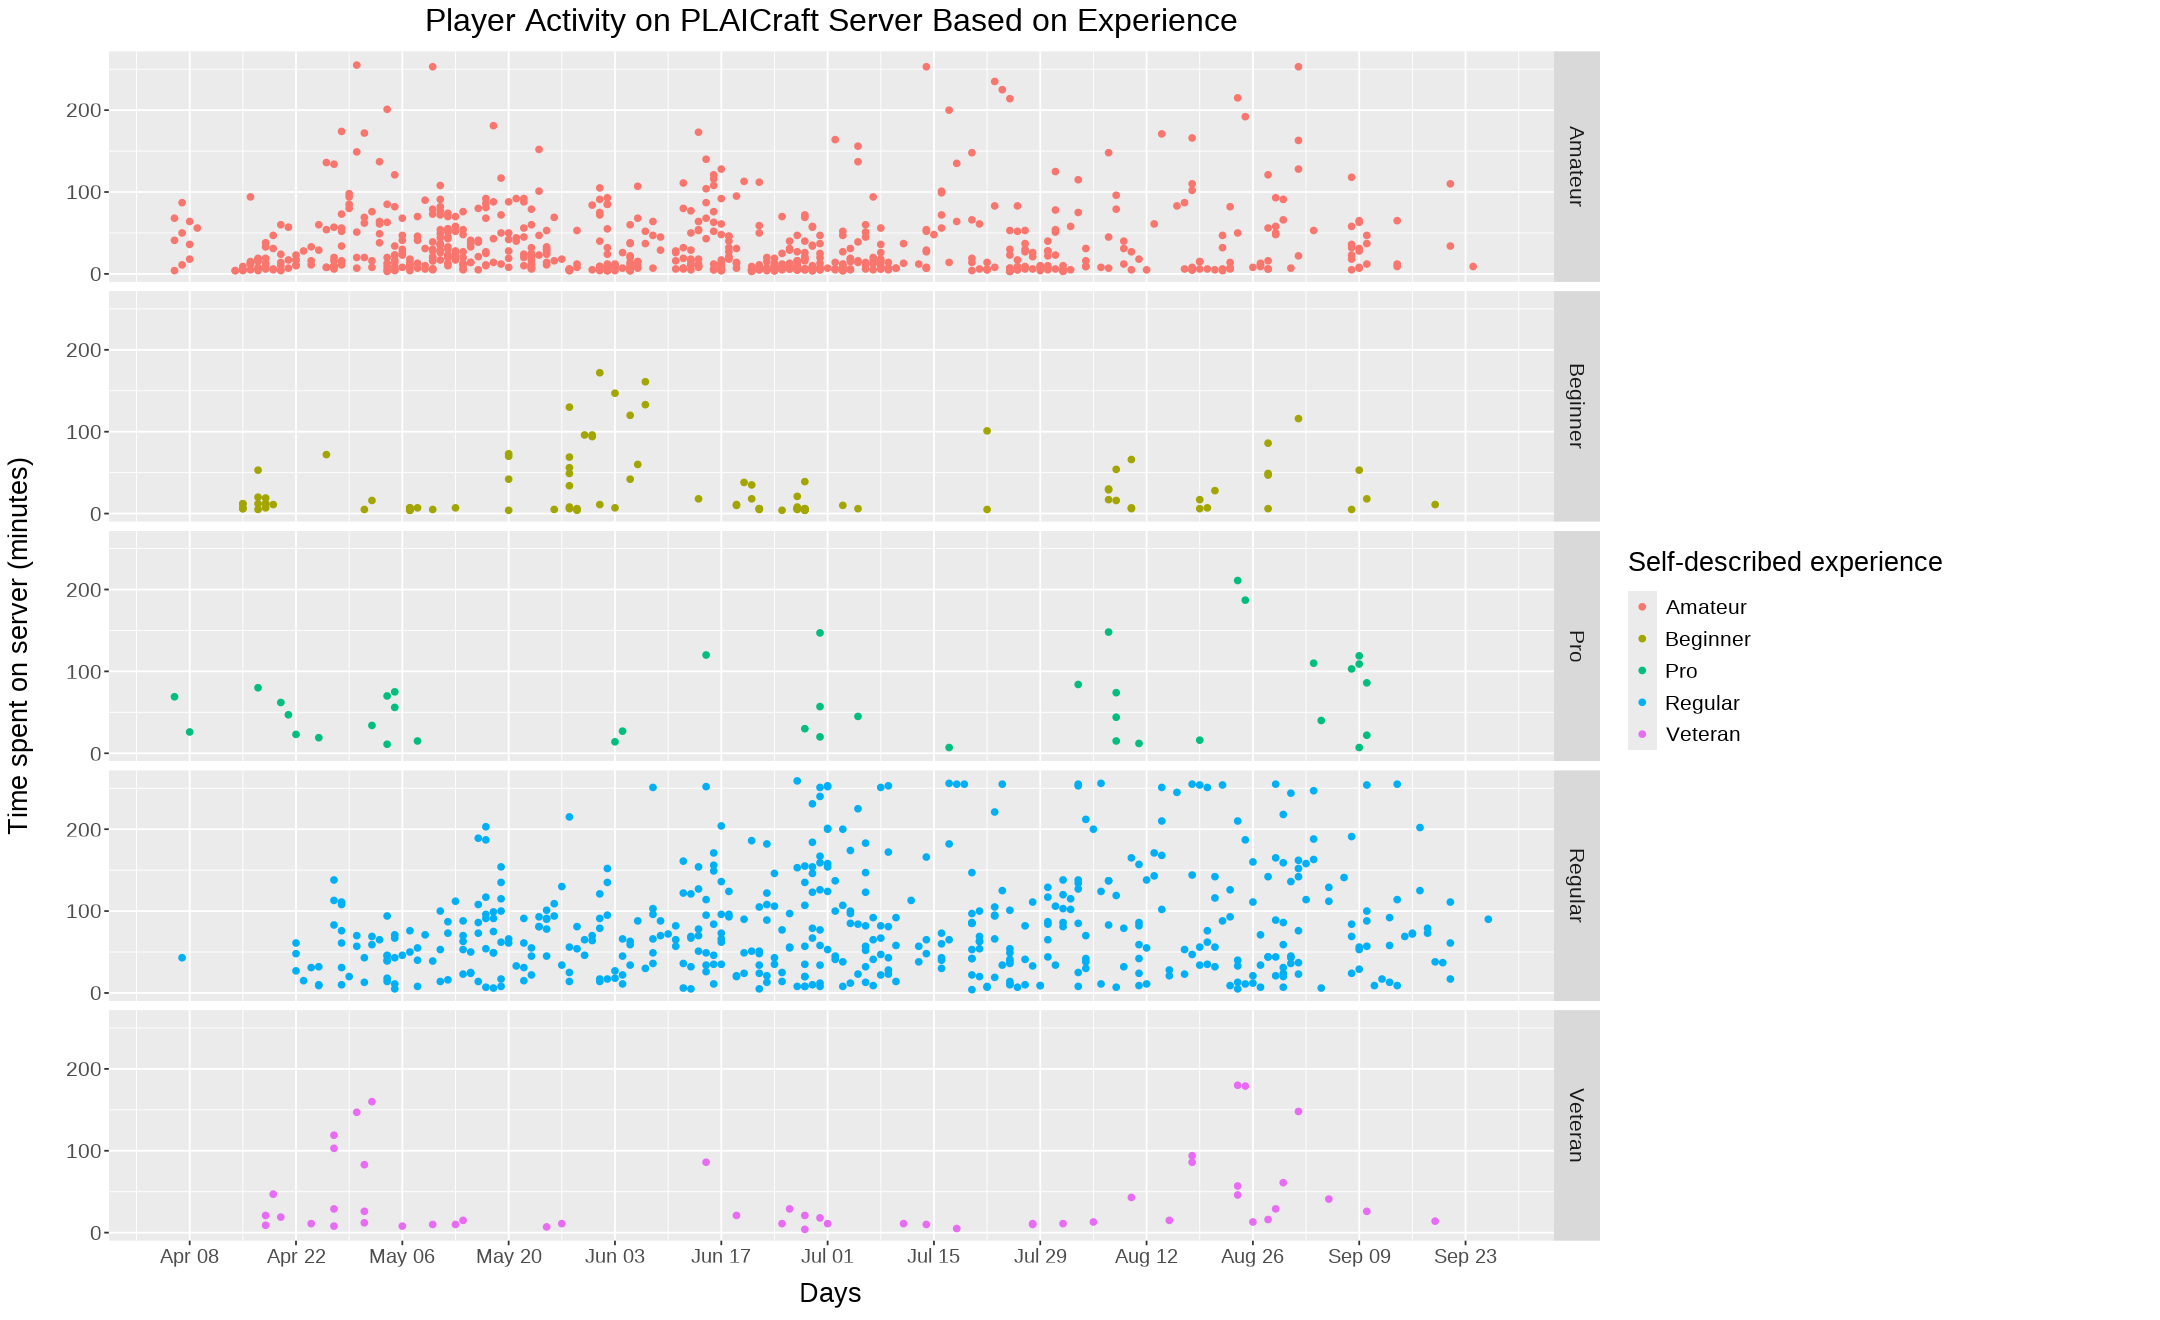

In [162]:
options(repr.plot.height = 11, repr.plot.width = 18)
server_activity <- server_data |>
    ggplot(aes(x = day, y = session_length, colour = experience)) +
        geom_point() +
        facet_grid(rows = vars(experience)) +
        scale_x_date(date_labels = "%b %d", date_breaks = "2 weeks") + # the date breaks argument ensures that the text doesn't overlap
        labs(x = "Days", y = "Time spent on server (minutes)", colour = "Self-described experience") +
        ggtitle("Player Activity on PLAICraft Server Based on Experience") +
        theme(plot.title = element_text(hjust = 0.5)) +
        theme(text = element_text(size = 20)) +
        theme(axis.text.x = element_text(size = 15))
server_activity

*<center>Figure 2: This scatter plot depicts how many hours are spent on the server per day based on a player's self-described experience. Each dot represents a single in-game session, and the time interval goes from April 6, 2024 to September 26, 2024. Every date that is labelled is a Monday.<center>*

In reality, the `Amateur` and `Regular` players contribute the most time to the server. As well, it appears like an overwhelming amount of sessions are **less than an hour**. This observation—of session length—might be able to explain potential flaws in our next section: data analysis.

### Performing data analysis

Now that we know that server activity is related to the time of week, let's narrow down our scope to player activity in a *single day*. We can take our existing dataframe, `sessions_proper_time`, to approximate how many people are simultaneously online every hour. This is achieved by rounding down to the nearest hour and summarizing how many rows there are. For example, if one person starts playing at 2:30 PM, and another starts playing at 2:14 PM, both values would get rounded down to 2:00 PM. When rounded down, there would be two observations of 2:00 PM on that day. Effectively, this gives us the number of players on the server within the time frame of an hour.

In [167]:
player_count <- sessions_proper_time |>
    mutate(hour = format(trunc(start_date, units = "hours"), format = "%H:%M")) |>
    group_by(day, hour) |>
    summarize(num_players = n()) |>
    mutate(hour = sub("(.{5})(.*)$", "\\1:00", hour)) |> # this notation adds a ":00" to the end of our time
    mutate(hour = hms(hour)) |>                          # with the added ":00" we can convert back to hours, minutes, seconds
    mutate(hour = as.numeric(hour)/3600)                 # finally, we can express our hour as a <dbl>; the original time is in seconds, so we convert to hours by dividing by 3600
head(player_count)                                       # this entire process will help when using our `hour` variable as a predictor

`summarise()` has grouped output by 'day'. You can override using the `.groups`
argument.


day        hour num_players
1 2024-04-06  9   2          
2 2024-04-06 20   1          
3 2024-04-06 22   1          
4 2024-04-07  0   1          
5 2024-04-07  2   1          
6 2024-04-07  5   2

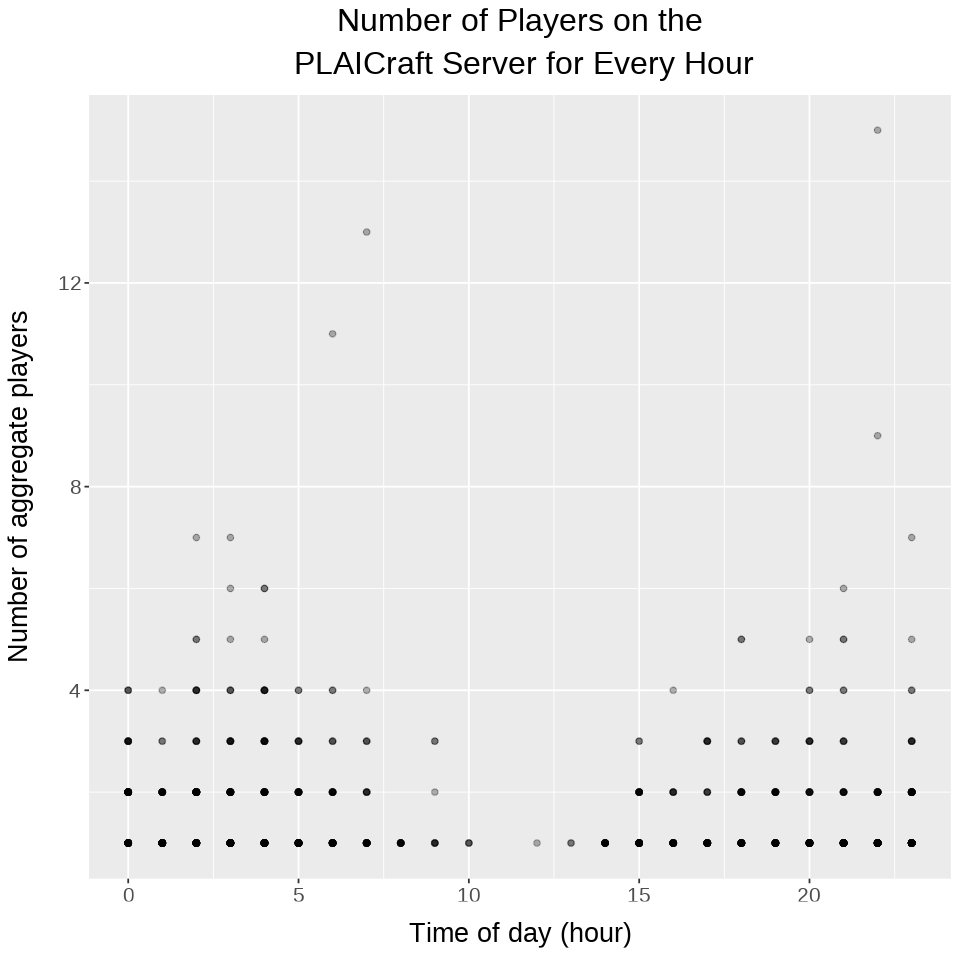

In [185]:
options(repr.plot.height = 8, repr.plot.width = 8)
players_over_time <- player_count |>
    ggplot(aes(x = hour, y = num_players)) +
        geom_point(alpha = 0.3) +
        labs(x = "Time of day (hour)", y = "Number of aggregate players") +
        ggtitle("Number of Players on the \n PLAICraft Server for Every Hour") +
        theme(plot.title = element_text(hjust = 0.5)) +
        theme(text = element_text(size = 20))
players_over_time

*<center>Figure 3: This scatter plot depicts how many players are on the server at a given hour. Each dot represents a single day, and the time interval goes from 0 hours (12 AM) to 23 hours (11 PM). An alpha value of 0.3 is chosen because some points overlap.<center>*

With our data, we can build a KNN regression model to predict the amount of players on the server based on the time of day. Simple linear regression would not fit this problem, as the relationship in our scatter plot is not linear. One possible limitation of KNN regression is that our predictions might be over/underfitted; however, we can mitigate this by tuning the model.

Not only does tuning the model avoid over/underfitting, but we can set `kvals` to less than 50 as to not choose too many neighbours (given that our dataset has 146 observations). From this, we cross-validate our model to choose the optimal K based on the lowest RMSE.

In [183]:
set.seed(3615)
player_split <- initial_split(player_count, prop = 0.7, strata = num_players)
player_testing <- testing(player_split)
player_training <- training(player_split)

kvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_cv <- vfold_cv(player_training, v = 5, strata = num_players)

players_recipe <- recipe(num_players ~ hour, data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) # as mentioned earlier, this is why converting the hour to a <dbl> instead of a <HMS> is necessary!

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_k <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_cv, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    filter(mean == min(mean)) 
players_k

neighbors .metric .estimator mean     n std_err   .config              
1 49        rmse    standard   1.191659 5 0.1111826 Preprocessor1_Model49

On the validation set, 49 neighbours perform the best. Given this value of $K$, we can re-specify our model.

In [179]:
knn_bestk_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 49) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_bestk_spec) |>
    fit(player_training) 

players_predict <- predict(players_fit, player_testing) |>
    bind_cols(player_testing)
head(players_predict)

.pred    day        hour num_players
1 1.510204 2024-04-06 22   1          
2 1.510204 2024-04-07  2   1          
3 1.469388 2024-04-07  5   2          
4 1.346939 2024-04-08  1   1          
5 1.653061 2024-04-08  3   1          
6 1.510204 2024-04-15 22   2

In [180]:
model_stats <- players_predict |>
    metrics(truth = num_players, estimate = .pred) |>
    filter(.metric == "rmse")
model_stats

.metric .estimator .estimate
1 rmse    standard   1.101709

Our fitted model reports an RMSPE of 1.1, meaning that our model is roughly off by 1 player. 

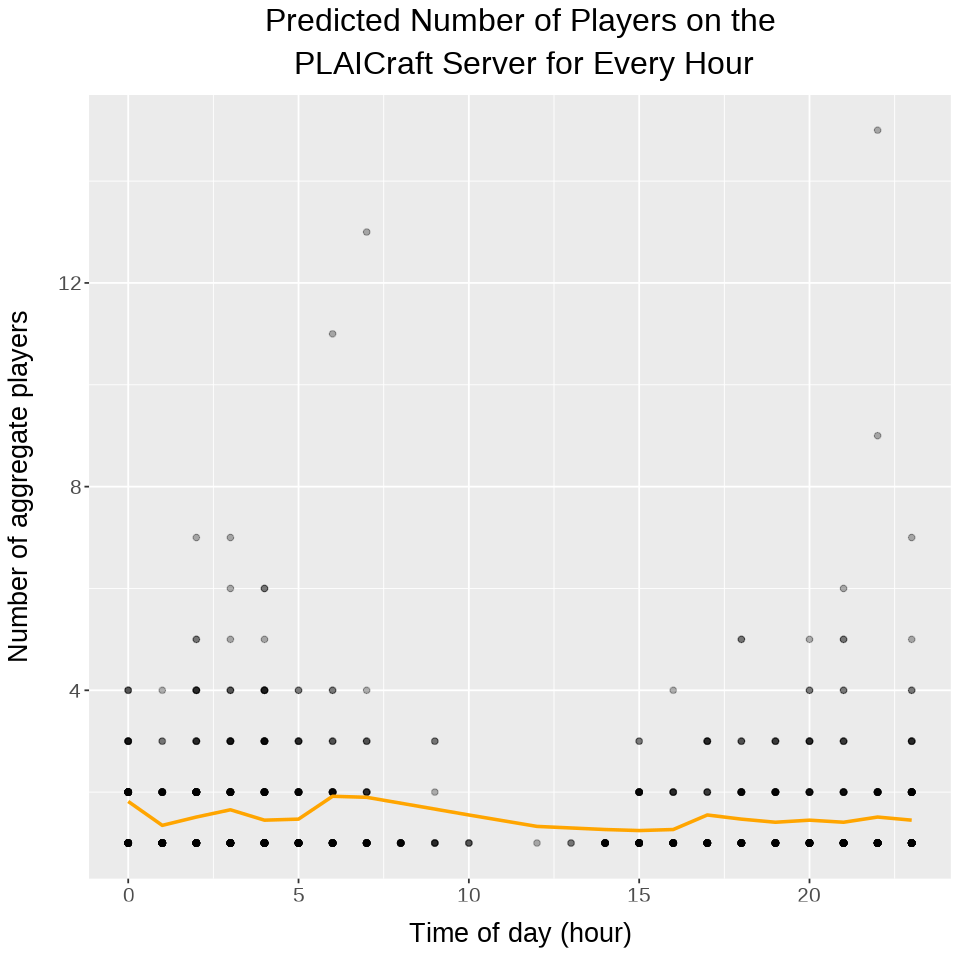

In [186]:
options(repr.plot.height = 8, repr.plot.width = 8)
model_graph <- player_count |>
    ggplot(aes(x = hour, y = num_players)) +
        geom_point(alpha = 0.3) +
        geom_line(data = players_predict, mapping = aes(x = hour, y = .pred), color = "orange", linewidth = 1) +
        labs(x = "Time of day (hour)", y = "Number of aggregate players") +
        ggtitle("Predicted Number of Players on the \n PLAICraft Server for Every Hour") +
        theme(plot.title = element_text(hjust = 0.5)) +
        theme(text = element_text(size = 20))
model_graph

*<center>Figure 4: This scatter plot depicts how many players are on the server at a given hour. The orange line is the predicted value of players based on KNN regression. Each dot represents a single day, and the time interval goes from 0 hours (12 AM) to 23 hours (11 PM). An alpha value of 0.3 is chosen because some points overlap.<center>*

# 3. Discussion

From our KNN regression model, it predicts that the majority of the server is only occupied by **one or two players** at a time. This may be true, as *Figure 2* confirms that most sessions are less than an hour, and that there are very few sessions on the same day. This means that the chances of simultaneous activity are low.

However, on a more general trend, we concluded that **during weekends the server has the most activity**, especially during July.

These results did not entirely meet my expectations, as I thought there would be more fluctuation in the server's player-base. On the other hand, I did expect the server to be more popular on weekends when people generally have more free time.

This data analysis could help PLAI's licensing and staffing by choosing to prioritize more resources during the summer. Another possibility would be to target certain demographics, like casual players who consider themselves `Amateurs` or `Regulars`, who might increase the activity of the server.

Some future lines of inquiry include:
* How might we track the consistency of a player's hours? And how could we incentivize this behaviour in the server?
* Is our regression suitable for predicting the number of players during the winter?
* Can we predict the player type based on session length?

These are questions that PLAI may explore, as they mine for further insights into technology, gaming, and AI.

# References

Ela. “How to Add a Character to a String in R - Stack Overflow.” Stack Overflow, 1 Aug. 2016, stackoverflow.com/questions/38704603/how-to-add-a-character-to-a-string-in-r/38704700#38704700.

John, Christopher. “R - Center Plot Title in GGPLOT2 - Stack Overflow.” Stack Overflow, 18 Nov. 2016, stackoverflow.com/questions/40675778/center-plot-title-in-ggplot2. 

PLAI. “Plaicraft FAQ.” PLAICraft Blog, 26 Jan. 2025, blog.plaicraft.ai/2024/10/25/plaicraft-faq/. 

Timbers, Tiffany, et al. “Chapter 7 Regression I: K-Nearest Neighbors: Data Science.” Data Science: A First Introduction, 21 Aug. 2024, datasciencebook.ca/regression1.html#. 